### Wet Snow Mapping Algorithm Using SAR Imagery

This notebook implements an algorithm for detecting and mapping wet snow using Synthetic Aperture Radar (SAR) data from Sentinel-1, based on the method developed by Nagler & Rott (2000).

**Reference:**

Nagler, T., & Rott, H. (2000). Retrieval of wet snow by means of multitemporal SAR data. *IEEE Transactions on Geoscience and Remote Sensing, 38*(2), 754–765. https://doi.org/10.1109/36.841980


In [48]:
import openeo
import geopandas as gpd
import leafmap
from query import query_s1
from openeo import processes as eop
from datetime import datetime, timedelta
import xarray as xr
import numpy as np

### Define the AOI
Read a shapefile with your AOI and show it in the map

In [49]:
shp_path = r'./input/SenalesCatchment.zip'

catchment_outline = gpd.read_file(shp_path)
bbox = catchment_outline.bounds.iloc[0]

center = (float(catchment_outline.centroid.y), 
          float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector(shp_path, layer_name="catchment")
m

Map(center=[46.72634837079619, 10.877755221904536], controls=(ZoomControl(options=['position', 'zoom_in_text',…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

### Connect and Authenticate

Connect to the Copernicus Dataspace Ecosystem (CDSE) backend 


In [50]:
eoconn = openeo.connect("https://openeo.dataspace.copernicus.eu/", auto_validate=False)
eoconn.authenticate_oidc()

eoconn.describe_account()

Authenticated using refresh token.


{'info': {'oidc_userinfo': {'email': 'valentina.premier@eurac.edu',
   'email_verified': True,
   'family_name': 'Premier',
   'given_name': 'Valentina',
   'name': 'Valentina Premier',
   'preferred_username': 'valentina.premier@eurac.edu',
   'sub': '1aa67f75-e178-495e-a131-9f7dffaaae18'}},
 'name': 'Valentina Premier',
 'user_id': '1aa67f75-e178-495e-a131-9f7dffaaae18'}

### Define parameters
Here the user is asked to define some parameters:
- date_s1 is the date that will be classified as wet/dry snow
- date_ref + ref_window is the timeframe for considering the reference period (snow free conditions, e.g., in the summer period)
- threshold to set for the ratio

In [51]:
date_s1 = '2024-06-15'
date_ref = '2023-08-09'
date_format = '%Y-%m-%d'

ref_window = 30 
threshold = -3 # in dB

Query in the ASF catalog to have an overview of the data and get the track number of the first available date after date_s1 and within 12 days

In [52]:
startdate = date_s1
new_date = datetime.strptime(date_s1, date_format) + timedelta(days=12)
enddate = new_date.strftime(date_format)

s1_list = query_s1(shp_path, startdate, enddate)
s1_list

Total matching Sentinel-1 data for the AOI: 5


,Date,fileName,track
4,2024-06-15,S1A_IW_GRDH_1SDV_20240615T171543_20240615T1716...,15
3,2024-06-21,S1A_IW_GRDH_1SDV_20240621T051858_20240621T0519...,95
2,2024-06-22,S1A_IW_GRDH_1SDV_20240622T170722_20240622T1707...,117
0,2024-06-26,S1A_IW_GRDH_1SDV_20240626T052732_20240626T0527...,168
1,2024-06-26,S1A_IW_GRDH_1SDV_20240626T052707_20240626T0527...,168


In [53]:
track = s1_list.sort_values(by='Date')['track'].iloc[0].astype(str)
track

'15'

### Select the Sentinel-1 image to classify
Take the first image available after date_s1. See documentation https://open-eo.github.io/openeo-python-client/data_access.html

In [54]:
s1 = eoconn.load_collection(
    "SENTINEL1_GRD",
    spatial_extent={'west':bbox[0],
                    'east':bbox[2],
                    'south':bbox[1],
                    'north':bbox[3],
                    'crs':4326},
    bands=['VV','VH'],
    temporal_extent=[startdate,enddate],
    properties={
        "relativeOrbitNumber": lambda x: x==track
    }
)

Apply the SAR preprocessing to calibrate and normalize for the terrain and convert from linear to dB by applying a Log with base 10.

In [56]:
s1 = s1.sar_backscatter(
                coefficient='sigma0-ellipsoid',
                elevation_model='COPERNICUS_30')
s1 = 10*s1.log10()
#s1.download("./results/s1_test.nc")

### Define the reference
Select the Sentinel-1 images to be used as reference (with the same track) and compute the temporal average

In [57]:
startdate = datetime.strptime(date_ref, date_format) - timedelta(days=ref_window)
startdate = startdate.strftime(date_format)

enddate = datetime.strptime(date_ref, date_format) + timedelta(days=ref_window)
enddate = enddate.strftime(date_format)

s1_ref = eoconn.load_collection(
    "SENTINEL1_GRD",
    spatial_extent={'west':bbox[0],
                    'east':bbox[2],
                    'south':bbox[1],
                    'north':bbox[3],
                    'crs':4326},
    bands=['VV','VH'],
    temporal_extent=[startdate,enddate],
    properties={
        "relativeOrbitNumber": lambda x: x==track
    }
)

Apply the SAR preprocessing to calibrate and normalize for the terrain. Convert from linear to dB.

In [58]:
s1_ref = s1_ref.sar_backscatter(
                coefficient='sigma0-ellipsoid',
                elevation_model='COPERNICUS_30')
s1_ref = 10*s1_ref.log10()
#s1_ref.download("./results/s1_reference.nc")

Query in the ASF catalog to have an overview of the data/track number

In [59]:
ref_list = query_s1(shp_path, startdate, enddate)
ref_list

Total matching Sentinel-1 data for the AOI: 25


,Date,fileName,track
24,2023-07-10,S1A_IW_GRDH_1SDV_20230710T170722_20230710T1707...,117
22,2023-07-14,S1A_IW_GRDH_1SDV_20230714T052733_20230714T0527...,168
23,2023-07-14,S1A_IW_GRDH_1SDV_20230714T052708_20230714T0527...,168
21,2023-07-15,S1A_IW_GRDH_1SDV_20230715T171543_20230715T1716...,15
20,2023-07-21,S1A_IW_GRDH_1SDV_20230721T051859_20230721T0519...,95
19,2023-07-22,S1A_IW_GRDH_1SDV_20230722T170723_20230722T1707...,117
18,2023-07-26,S1A_IW_GRDH_1SDV_20230726T052708_20230726T0527...,168
17,2023-07-26,S1A_IW_GRDH_1SDV_20230726T052733_20230726T0527...,168
16,2023-07-27,S1A_IW_GRDH_1SDV_20230727T171544_20230727T1716...,15
15,2023-08-02,S1A_IW_GRDH_1SDV_20230802T051859_20230802T0519...,95


Check that the output dataset has been correctly filtered based on the track

In [60]:
s1_ref_xr = xr.open_dataset("./results/s1_reference.nc")
s1_ref_xr

FileNotFoundError: [Errno 2] No such file or directory: b'/home/vpremier/Documents/git/OEMC/wet_snow/results/s1_reference.nc'

Compute the mean over time to define the reference 

In [61]:
s1_mean = s1_ref.reduce_dimension(reducer="mean",dimension="t")
#s1_mean.download("./results/s1_mean.nc")

Compute the difference w.r.t. the reference and VV and VH average ratio

In [64]:
s1_ratio = s1 - s1_mean
s1_ratio_mean = s1_ratio.reduce_dimension(reducer="mean",dimension="bands")
#s1_ratio_mean.download("./results/s1_ratio_mean.nc")

Resample to 100 m spatial resolution to filter the noise

In [65]:
s1_ratio_mean

In [66]:
s1_ratio_fltd = s1_ratio_mean.resample_spatial(resolution=100, method = "mean")
#s1_ratio_fltd.download("./results/s1_ratio_100.nc"s1_ratio_fltd.download("./results/s1_ratio_100.nc"ù)

Compute the wet snow map, download the result and visualize it

In [69]:
s1_ratio_fltd = s1_ratio_mean < threshold
s1_ratio_fltd.download("./results/s1_ws_100_new.nc")

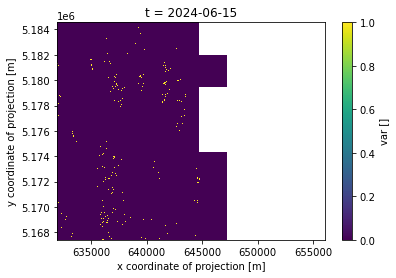

In [70]:
s1_ws_xr = xr.open_dataset("./results/s1_ws_100_new.nc")
s1_ws_xr = s1_ws_xr.where(s1_ws_xr != 129, np.nan) #mask no data
s1_ws_xr['var'].plot()

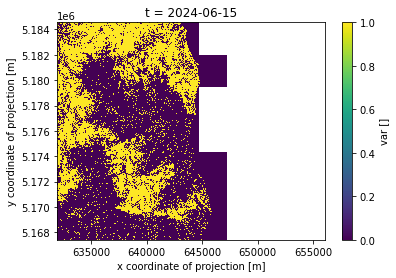

In [26]:
s1_ws_xr = xr.open_dataset("./results/s1_ws.nc")
s1_ws_xr = s1_ws_xr.where(s1_ws_xr != 129, np.nan) #mask no data
s1_ws_xr['var'].plot()